In [16]:
import matplotlib
from scipy.stats import poisson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import trange 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class CarRental:
    def __init__(self,const_ret_cars = True):
        self.max_cars = 20
        self.max_move_cars = 5
        self.rent_req_loc1 = 3
        self.rent_req_loc2 = 3
        self.ret_loc1 = 3
        self.ret_loc2 = 2
        self.discount = 0.9
        self.rent_credit = 10
        self.move_car_cost = 2
        self.add_park_cost = -4
        self.actions = np.arange(-self.max_move_cars, self.max_move_cars + 1)
        self.truncate = 11
        self.values = np.zeros((self.max_cars + 1, self.max_cars + 1))
        self.const_ret_cars = const_ret_cars
        self.policy = np.zeros(self.values.shape, dtype=np.int)
        self.poisson_prob_dict = dict()


    def compPoissonProb(self,n, lam):
        key = n * 10 + lam
        if key not in self.poisson_prob_dict:
            self.poisson_prob_dict[key] = poisson.pmf(n, lam)
        return self.poisson_prob_dict[key]

    def getValues(self):
        return self.values

    def getPolicy(self):
        return self.policy

    def solveBellman(self,state, action, state_value):

        returns = 0.0

        if action > 0:
            returns -= self.move_car_cost * (action - 1)
        else:
            returns -= self.move_car_cost * abs(action)
            
        for req_loc1 in range(self.truncate):
            for req_loc2 in range(self.truncate):

                prob = self.compPoissonProb(req_loc1, self.rent_req_loc1) * \
                    self.compPoissonProb(req_loc2, self.rent_req_loc2)

                num_cars_loc1, num_cars_loc2 = min(state[0] - action, self.max_cars), min(state[1] + action, self.max_cars)

                rental_loc1, rental_loc2 = min(num_cars_loc1, req_loc1), min(num_cars_loc2, req_loc2)

                reward = (rental_loc1 + rental_loc2) * self.rent_credit
                
                if num_cars_loc1 >= 10:
                    reward += self.add_park_cost
                if num_cars_loc2 >= 10:
                    reward += self.add_park_cost
                
                num_cars_loc1 -= rental_loc1
                num_cars_loc2 -= rental_loc2

                if self.const_ret_cars:
                    ret_cars_loc1 = self.ret_loc1
                    ret_cars_loc2 = self.ret_loc2
                    num_cars_loc1 = min(num_cars_loc1 + ret_cars_loc1, self.max_cars)
                    num_cars_loc2 = min(num_cars_loc2 + ret_cars_loc2, self.max_cars)
                    returns += prob * (reward + self.discount * state_value[num_cars_loc1, num_cars_loc2])
                else:
                    for ret_cars_loc1 in range(self.truncate):
                        for ret_cars_loc2 in range(self.truncate):
                            prob_return = self.compPoissonProb(
                                ret_cars_loc1, self.ret_loc1) * self.compPoissonProb(ret_cars_loc2, self.ret_loc2)
                            num_cars_loc1_ret = min(num_cars_loc1 + ret_cars_loc1, self.max_cars)
                            num_cars_loc2_ret = min(num_cars_loc2 + ret_cars_loc2, self.max_cars)
                            prob_ret = prob_return * prob
                            returns += prob_ret * (reward + self.discount * state_value[num_cars_loc1_ret, num_cars_loc2_ret])
                
        return returns


    def policyEvaluation(self,value,policy):
        while True:
                old_value = value.copy()
                for i in range(self.max_cars + 1):
                    for j in range(self.max_cars + 1):
                        new_state_value = self.solveBellman([i, j], policy[i, j], value)
                        value[i, j] = new_state_value
                max_delta = abs(old_value - value).max()
                print(f'max delta: {max_delta}')
                if max_delta < 1e-4:
                    break

        return value 

    def policyImprovement(self,policy,value):
        policy_stable = True
        for i in range(self.max_cars + 1):
            for j in range(self.max_cars + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in self.actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(self.solveBellman([i, j], action, value))
                    else:
                        action_returns.append(-np.inf)
                new_action = self.actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print(f'policy stable {policy_stable}')
        return policy, policy_stable


    def exercise_4_7(self):
        iter_cnt = 0
        
        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        axes = axes.flatten()
        
        while True:
            fig = sns.heatmap(np.flipud(self.policy), cmap="YlGnBu", ax=axes[iter_cnt])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(self.max_cars + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy {}'.format(iter_cnt), fontsize=30)

            self.values = self.policyEvaluation(self.values,self.policy)

            self.policy, policy_stable = self.policyImprovement(self.policy,self.values)

            if policy_stable:
                fig = sns.heatmap(np.flipud(self.values), cmap="YlGnBu", ax=axes[-1])
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(self.max_cars + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('optimal value', fontsize=30)
                break

            iter_cnt += 1
        print('iterations:',iter_cnt+1)
        plt.show()




max delta: 125.81838835702585
max delta: 90.25866770389791
max delta: 69.71404191414197
max delta: 55.74455926258233
max delta: 47.782454208220145
max delta: 40.16824795525096
max delta: 33.31956588696164
max delta: 27.40568433136758
max delta: 22.93020247634621
max delta: 19.76672805404195
max delta: 16.992633665186418
max delta: 14.57882655758982
max delta: 12.48933144685418
max delta: 10.686997549573846
max delta: 9.13627455746041
max delta: 7.804490691301908
max delta: 6.662329782868198
max delta: 5.683875917625755
max delta: 4.846435246376245
max delta: 4.130256472948645
max delta: 3.5182183531739497
max delta: 2.995520271369344
max delta: 2.549393141582584
max delta: 2.168837504275075
max delta: 1.8443903170295926
max delta: 1.567919360668327
max delta: 1.3324430833307588
max delta: 1.1319733486263885
max delta: 0.9613785499165033
max delta: 0.8162647029293453
max delta: 0.6928723367641965
max delta: 0.5879872239213455
max delta: 0.4988632033799263
max delta: 0.4231555490647452
m

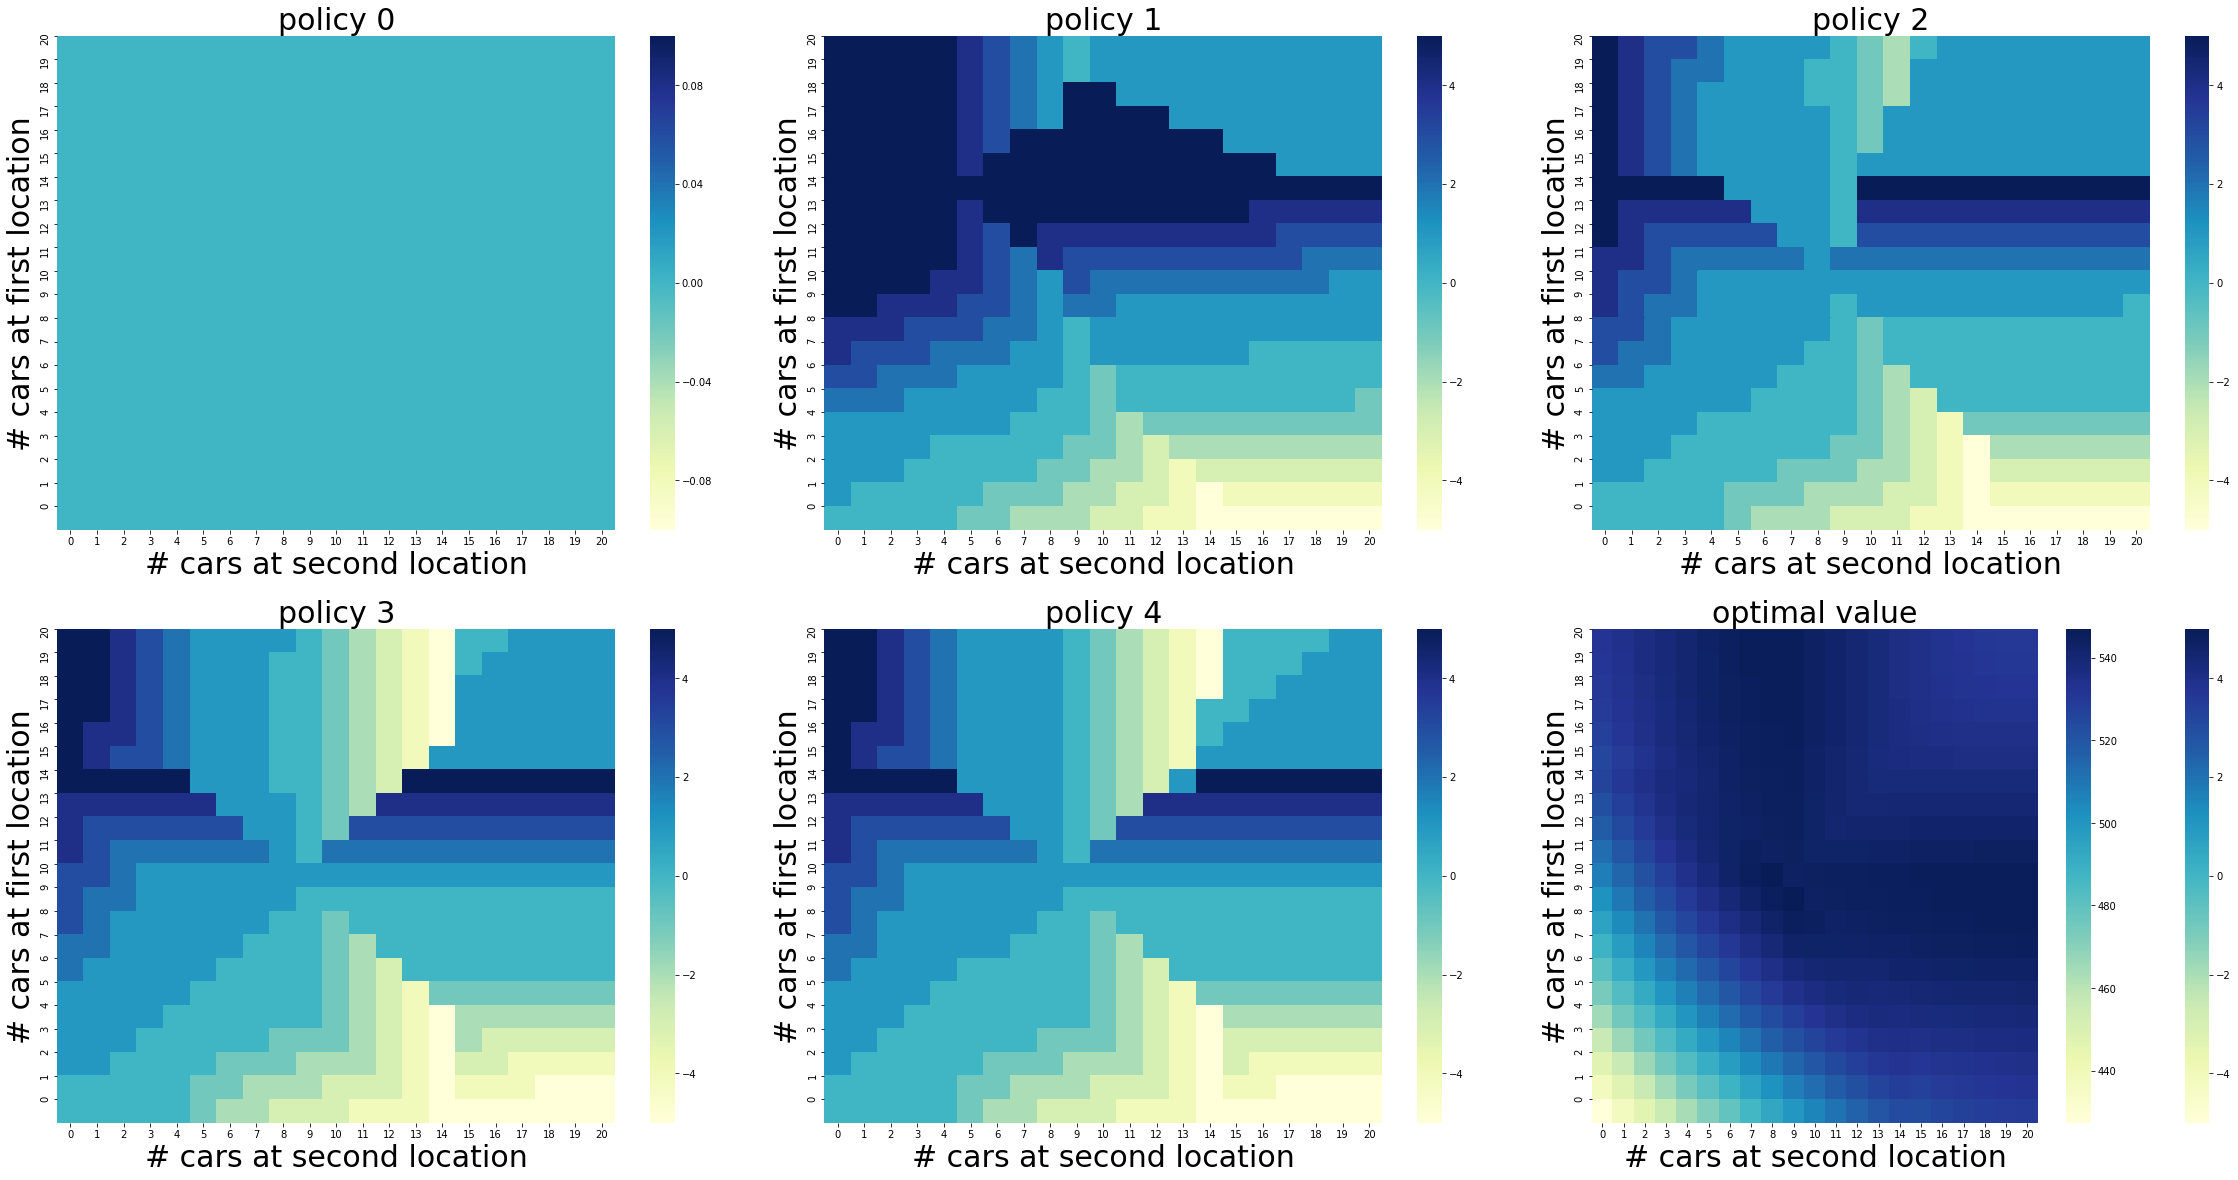

In [3]:
car = CarRental()
car.exercise_4_7()

In [41]:
def plot3dValues(values):
    x = np.arange(21)
    y = np.arange(21)
    x,y = np.meshgrid(x,y)
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x,y,values,rstride=1,cstride=1,cmap='hot',linewidth=0,antialiased=False)
    ax.set_xlabel('# cars at location 1')
    ax.set_ylabel('# cars at location 2')
    ax.set_title('Optimal Value')
    fig.colorbar(surf,shrink = 0.5, aspect = 5)
    plt.show()

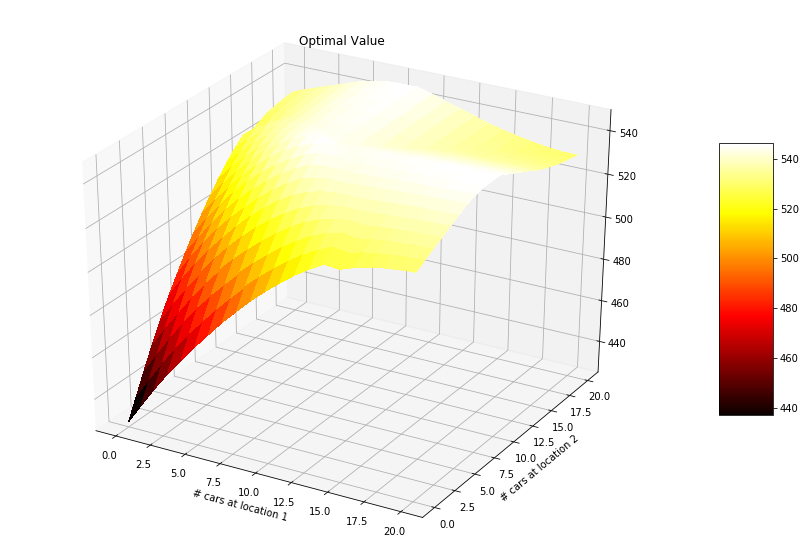

In [42]:
values = car.getValues()
plot3dValues(values)
# fig = plt.figure()
# # ax = fig.gca(projection='3d')

In [15]:
print(values)

[[427.33143045 437.22369935 446.77469263 455.7242556  463.91340155
  471.77820697 479.22477657 486.56197972 493.20443809 499.69508106
  505.52121206 510.91972016 515.93604482 520.3042905  524.05186863
  523.27086459 525.69602682 527.41778923 528.58074362 529.35306386
  529.89227052]
 [437.22369944 447.11419441 456.65956102 465.59986805 473.77820697
  481.22477657 488.56197972 495.20443809 501.69508106 507.52121206
  512.91972016 517.93604482 522.3042905  526.05186863 528.75234227
  527.69602682 529.41778923 530.58539245 531.40952522 531.97376045
  532.39766291]
 [447.11419441 456.65956133 466.18528238 475.09044038 483.22477657
  490.56197972 497.20443809 503.69508106 509.52121206 514.91972016
  519.93604482 524.3042905  528.05186863 530.75234227 532.49109874
  531.41778923 532.58539245 533.40952522 533.97376045 534.39766291
  534.75021851]
 [456.65956133 466.18528238 475.09044094 483.92708773 491.96856164
  499.20444045 505.69508344 511.5212145  516.91972229 521.93604704
  526.30429284

In [ ]:
car = CarRental(const_ret_cars = False)
car.exercise_4_7()

max delta: 129.78999576385263
max delta: 93.30183222552284
max delta: 70.41835284150426
max delta: 55.046185362436944
max delta: 47.05017729252066
max delta: 39.27140127526269
max delta: 32.375003454348075
max delta: 26.527794539426793
max delta: 21.6806764610389
max delta: 17.70639860820131
